c:\Users\cayez\Documents\DONNEES_SIMON\git\Workshop_nino



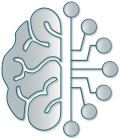

**Start at:** Friday 26 September 2025, 10:19:25  
**Hostname:** insa-09521 (Windows)

<p style="text-align: center"><img width="800px" src="./config/svg/pyPhysChemBanner.svg" style="margin-left:auto; margin-right:auto"/></p>

In [1]:
import os
import sys

print(os.getcwd())
cwd0 = './config/'
sys.path.append(cwd0)

import visualID_Eng as vID
from visualID_Eng import fg,bg,hl,color
vID.init(cwd0)

import tools4pyPhysChem as t4pPC

#cancel the "last show-up" behaviour of Jupyter notebooks
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

__author__ = "Simon Cayez, LPCNO / Département Génie Physique (INSA Toulouse, France)"

<h2 style="text-align: center;">
  <b><u>Dataset Preparation</u>:<br>
  Step 2 – Full Dataset Assembly and CNN Training</b>
</h2>


In the previous notebook, we processed the images for each shape separately, preparing them for deep learning.  
In this notebook, we will **aggregate the three classes** (`circle`, `triangle`, `square`) into a single dataset, **assign labels**, **shuffle and normalize** the data, and **split it into training and test sets**.  

Finally, we will **train a 2D CNN** on this dataset and **make predictions**.  
This notebook continues directly from the previous one: [Step 1 – Image Processing](image_processing.ipynb).


## 1- Create Numpy array datasets with all geometries

### 1-1- Images array (X)

#### 1-1-1- Load images

Load the preprocessed images for each shape as NumPy arrays and check their dimensions. Use `np.load`


In [2]:
import numpy as np
import os

base_dir = 'data/'

path_circle = os.path.join(base_dir,"circle_data_preprocess.npy")
path_square = os.path.join(base_dir,"square_data_preprocess.npy")
path_triangle = os.path.join(base_dir,"triangle_data_preprocess.npy")


circle = np.load(path_circle)
square = np.load(path_square)    # (N2, 128, 128)
triangle = np.load(path_triangle)# (N3, 128, 128

print(circle.shape)
print(square.shape)
print(triangle.shape)

(616, 128, 128)
(535, 128, 128)
(691, 128, 128)


#### 1-1-2- Concatenate arrays

**concatenate** the three image arrays (`circle`, `square`, `triangle`) along the first axis to combine them into a single dataset `X`.

- Before concatenation:  
  - `circle` : shape `(a, 128, 128)`  
  - `square` : shape `(b, 128, 128)`  
  - `triangle`: shape `(c, 128, 128)`  

- After concatenation:  
  - `X` : shape `(a+b+c, 128, 128)`  

This combined array `X` now contains **all images from the three classes** in one single dataset.


In [3]:
X = np.concatenate([circle, square, triangle], axis=0) 
print(X.shape)

(1842, 128, 128)


#### 1-2- Labels array (y)

#### 1-2-1- Create labels arrays

Create the **labels** for each image set.  
In a classification problem, a **label** is a numeric value representing the class of each sample.  

- All circle images are assigned the label `0`  
- All square images are assigned the label `1`  
- All triangle images are assigned the label `2`  
 **create the corresponding labels** for each shape.  
For this, we build three NumPy arrays:  

- One filled with `0` for circles (`len(circle)` elements)  
- One filled with `1` for squares (`len(square)` elements)  
- One filled with `2` for triangles (`len(triangle)` elements)  

These arrays give each image its **class label** (circle, square, triangle) and will be combined with the image data in the next step.

In [4]:
y_circle = np.zeros(len(circle), dtype=int)           # classe 0
y_square = np.ones(len(square), dtype=int)            # classe 1
y_triangle = np.full(len(triangle), 2, dtype=int) 

print(y_circle.shape)
print(y_square.shape)
print(y_triangle.shape)

(616,)
(535,)
(691,)


#### 1-1-2- Concatenate arrays

**concatenate** the three label arrays (`y_circle`, `y_square`, `y_triangle`) into a single array `y` using `np.concatenate`.  

- Before concatenation, we had three separate 1-D arrays of shapes `(a,)`, `(b,)`, and `(c,)`.  
- After concatenation, we obtain a single 1-D array of shape `(a+b+c,)`, which contains the labels for **all images combined** (circles, squares, and triangles).  

The variable name `y` is the **convention in machine learning** again, to denote the array of **labels/targets** corresponding to the input data `X`.
We name the combined image array **`X`** because, by convention in machine learning, `X` represents the **input data** (features) fed into a model.  


In [5]:
y = np.concatenate([y_circle, y_square, y_triangle], axis=0)
print(y.shape)

(1842,)


Now the NumPy arrays are prepared. We have:

- A **stack of images**:
  - The first *a* images are **circles**  
  - The next *b* images are **squares**  
  - The following *c* images are **triangles**

- And a **label array**:
  - The first *a* values are **0**  
  - The next *b* values are **1**  
  - The following *c* values are **2**  

Keep in mind the correspondence between labels and classes:

- **0 = circle**  
- **1 = square**  
- **2 = triangle**


To get an overview of the dataset, we can create a video of the image sequence and overlay a small shape on each frame to indicate its label.  
This is done with the function `create_video_from_images_with_labels`.  

For the shapes, we use OpenCV drawing functions:  
- `cv2.circle` for circles  
- `cv2.rectangle` for squares  
- `cv2.fillPoly` for triangles  


In [ ]:
from vizualisation import create_video_from_images_with_labels
create_video_from_images_with_labels(X, y, output_path='data/video_shuffleXy.mp4', fps=5)

## 2- Prepare dataset for buiding Keras Tensorflow model

### 2-1- Add a Channel Dimension

Our current data array `X` has the shape `(n_samples, 128, 128)`, which represents  
`n_samples` grayscale images of size `128 × 128`.

However, most **Keras/TensorFlow CNN layers** expect an input shape of  
`(n_samples, height, width, channels)` — the last dimension corresponds to the number of channels  
(e.g. `3` for RGB images, `1` for grayscale).

In short, we will have to pass from `(n_samples, 128, 128)` to `(n_samples, 128, 128, 1)`


To make our grayscale images compatible with CNNs, we need to **add a channel dimension** equal to `1`.  
We can do this with:

In [6]:
print(X.shape)
X = X[:, :, :, np.newaxis]
print(X.shape)

(1842, 128, 128)
(1842, 128, 128, 1)


### 2-2- Shuffle data

  Shuffling randomly mixes samples so that the order of data (e.g., all circles first, then all squares, then all triangles) does not bias the training process.  
  This ensures that batches fed to the model are representative of all classes and helps the model learn better.

#### 2-2-1- Set random seeds

Setting seeds (for NumPy, Python’s `random`, TensorFlow, etc.) forces all random operations to produce the same sequence of random numbers each time you run the script.  
this makes your data preparation and model training **reproducible** — you’ll get the same shuffled dataset and the same initial weights at every run.

In [7]:
import random
import tensorflow as tf
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

#### 2-2-2- Apply Shuffle

Now use `sklearn.utils.shuffle` to randomly reorder `X` and `y` **in the same way** so that the correspondence between images and labels is preserved:

In [8]:
from sklearn.utils import shuffle

X, y = shuffle(X, y, random_state=seed)
print(y)

[2 2 0 ... 1 2 1]


### 2-3- Split Dataset into Training and Test Sets  

After shuffling, we split our dataset into **training** and **test** sets.  
- The **training set** is used to train the CNN.  
- The **test set** is used to evaluate its performance on unseen data.  

We use `train_test_split` from `sklearn.model_selection`, with the following considerations:  
- `test_size=0.2` → 20% of the data is reserved for testing.  
- `random_state=seed` → ensures reproducibility.  
- `stratify=y` → preserves the class proportions in both training and test sets.

In [11]:
from sklearn.model_selection import train_test_split

# Suppose que X et y sont déjà construits
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,         # 20% en test
    random_state=seed,       # pour reproductibilité
    stratify=y             # pour garder la proportion des classes
)

print(f"Training set: X_train = {X_train.shape}, y_train = {y_train.shape}")
print(f"Test set:     X_test  = {X_test.shape}, y_test  = {y_test.shape}")

Training set: X_train = (1473, 128, 128, 1), y_train = (1473,)
Test set:     X_test  = (369, 128, 128, 1), y_test  = (369,)


## 3- Convolutional Neural Network (CNN)

### 3-1 — Create a 2D CNN Model

Now that the dataset is ready, we can define a **2D CNN** for classifying our images into three classes: circle, square, or triangle.  

Our model uses the following layers:

1. **Conv2D + ReLU** → Extracts spatial features from the images.  
2. **MaxPooling2D** → Reduces spatial dimensions while keeping important features.  
3. **Another Conv2D + ReLU** → Learns more complex patterns.  
4. **MaxPooling2D** → Further reduces feature map size.  
5. **Flatten** → Converts 2D feature maps into a 1D vector for the dense layers.  
6. **Dense (64, ReLU)** → Fully connected layer to combine features.  
7. **Dense (3, softmax)** → Output layer with 3 neurons for our 3 classes.  

We compile the model using:  
- **Optimizer:** `adam`  
- **Loss function:** `sparse_categorical_crossentropy` (because our labels are integer-encoded)  
- **Metric:** `accuracy` to monitor performance during training.  


In [12]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(X.shape[1],X.shape[2],X.shape[3])),
    #layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')  # 3 classes
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])




c:\Users\cayez\Documents\DONNEES_SIMON\python_env\donnees\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### 3-2- Train model

**Training a model** means adjusting its internal parameters (weights and biases) so that it can learn to map input data (`X_train`) to the correct output labels (`y_train`).  
During training, the model makes predictions on the input data, computes the error (loss) compared to the true labels, and updates its parameters using an optimization algorithm (here, **Adam**) to minimize this error.

- **`X_train` and `y_train`**: the input images and their corresponding labels for training.  
- **`epochs=20`**: the model will iterate 20 times over the entire training dataset.  
- **`batch_size=64`**: the number of samples processed before the model updates its weights.  
- **`validation_split=0.2`**: 20% of the training data is held out for validation to monitor performance during training.  
- **`verbose=1`**: print progress and metrics for each epoch.

The function returns a `history` object that stores the evolution of training and validation metrics over epochs, which can be used later for plotting learning curves.


In [13]:

history = model.fit(
    X_train, y_train,          
    epochs=20,                
    batch_size=64,            
    validation_split=0.2,      
    verbose=1                 
)

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 519ms/step - accuracy: 0.3450 - loss: 1.1199 - val_accuracy: 0.4203 - val_loss: 1.0796
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 455ms/step - accuracy: 0.3839 - loss: 1.0846 - val_accuracy: 0.4203 - val_loss: 1.0390
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 495ms/step - accuracy: 0.4715 - loss: 1.0404 - val_accuracy: 0.7017 - val_loss: 0.8796
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 503ms/step - accuracy: 0.6586 - loss: 0.8334 - val_accuracy: 0.6881 - val_loss: 0.6596
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 468ms/step - accuracy: 0.7955 - loss: 0.5377 - val_accuracy: 0.7186 - val_loss: 0.5395
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 477ms/step - accuracy: 0.8523 - loss: 0.3798 - val_accuracy: 0.9356 - val_loss: 0.2217
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 447ms/step - accuracy: 0.8685 - loss: 0.2757 - val_accuracy: 0.7864 - val_loss: 0.4739
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 470ms/step - accuracy: 0.8906 - loss: 0.2514 - val_accuracy: 

### 3-3- Evaluate model performances

#### 3-3-1- Plot metrics

After training, we can **visualize how the model’s performance evolved** over epochs.  
Here, we plot the **training accuracy** and **validation accuracy** for each epoch.  

- **Training accuracy** shows how well the model fits the training data.  
- **Validation accuracy** shows how well the model generalizes to unseen data (here, a fraction of the training set held out for validation).  

By comparing the two curves, we can detect **overfitting** (training accuracy much higher than validation) or **underfitting** (both accuracies low).


Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Accuracy')

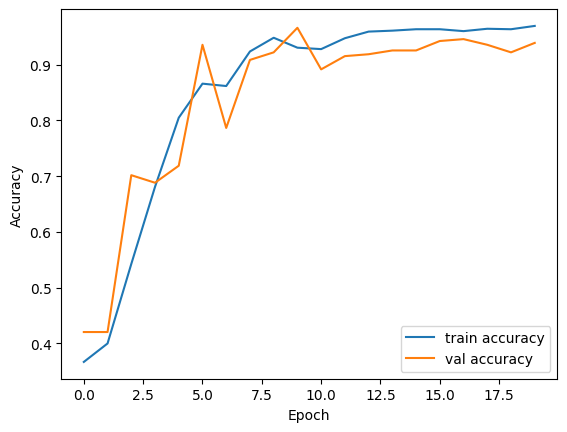

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### 3-3-2- Predictions on test dataset

##### 3-3-3-2- Compute prediction

Now that the model is trained, we can **make predictions on the test set**.  
We will compute the predicted class for each test image by taking the class with the highest probability.  

In [15]:
y_pred_proba = model.predict(X_test)              # probability for each class (nb_images, 3)
y_pred = np.argmax(y_pred_proba, axis=1)          # prdicted class (0 or 1 or 2)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


After predicting on the test set, `y_pred_proba` contains the **predicted probabilities for each class** for every image, while `y_pred` contains the **predicted class** based on the maximum probability.
For example, for the first 5 images:

In [16]:
# Probabilities for each class
print("Predicted probabilities for the first 5 test images:")
for i, probs in enumerate(y_pred_proba[:5]):
    print(f"Image {i}: {probs}")

# Predicted class
print("\nPredicted classes for the first 5 test images:")
for i, pred in enumerate(y_pred[:5]):
    print(f"Image {i}: class {pred}")

Predicted probabilities for the first 5 test images:
Image 0: [4.4256383e-05 6.0916107e-05 9.9989486e-01]
Image 1: [1.3613629e-09 3.3566978e-09 1.0000000e+00]
Image 2: [0.36044535 0.63219297 0.00736163]
Image 3: [5.1023747e-04 1.5325215e-05 9.9947447e-01]
Image 4: [9.9999881e-01 7.1403264e-07 4.7659086e-07]

Predicted classes for the first 5 test images:
Image 0: class 2
Image 1: class 2
Image 2: class 1
Image 3: class 2
Image 4: class 0


#### 3-3-3- Accuracy and confusion matrix

##### 3-3-3-1 — Compute Test Accuracy

Once we have the predicted classes (`y_pred`) for the test set, we can measure how well our CNN performs using the **accuracy score**.

In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix
# --- accuracy ---
acc = accuracy_score(y_test, y_pred)

print(f"Accuracy on test set: {acc:.3f}")
print(f"Meaning: {100*acc:.1f}% of the predictions are correct")


# print(f"Accuracy on test : {acc:.3f}")
# print(f"Meaning : {100*acc:.1f}% of good predictions")

Accuracy on test set: 0.935
Meaning: 93.5% of the predictions are correct


##### 3-3-3-1- Confusion matrix

A **confusion matrix** is a table that summarizes the performance of a classification model by comparing the **true labels** `(y_test)` with the **predicted labels** `(y_pred)`.

In [18]:
cm = confusion_matrix(y_test, y_pred)
print("Matrice de confusion :")
print(cm)

Matrice de confusion :
[[123   0   0]
 [ 18  85   4]
 [  1   1 137]]


We can visualize the confusion matrix as a **heatmap** to make it easier to interpret the model's performance.

- Each **cell** shows the number of samples with a given true label (row) predicted as a given class (column).  
- The **diagonal** shows the correctly classified samples.  
- The **off-diagonal** shows misclassifications.  
- Using colors (Blues) allows us to quickly see which classes are predicted well (darker = more samples).  

The x-axis represents the **predicted classes**, the y-axis the **true classes**.  
The **accuracy** of the model is also displayed in the title for quick reference.

<Figure size 600x500 with 0 Axes>

<Axes: >

Text(0.5, 25.722222222222214, 'Prediction')

Text(45.722222222222214, 0.5, 'True')

Text(0.5, 1.0, 'Matrice de confusion (Accuracy 93.50%)')

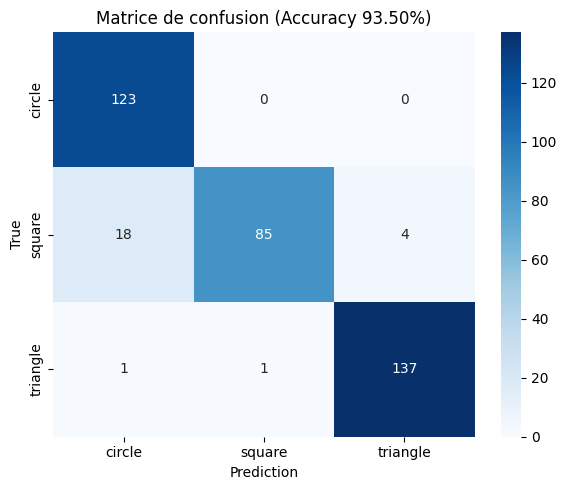

In [19]:
import seaborn as sns
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['circle','square','triangle'],
            yticklabels=['circle','square','triangle'])
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title(f'Matrice de confusion (Accuracy {acc:.2%})')
plt.tight_layout()
plt.show()


In [20]:

# model : ton modèle Keras
def model_size_and_params(model, dtype_size=4):
    params = model.count_params()
    # approx size in bytes (float32 = 4 bytes)
    size_bytes = params * dtype_size
    size_mb = size_bytes / (1024**2)
    return params, size_mb

In [21]:
import time
def file_size_mb(path):
    """Retourne la taille d’un fichier en MB"""
    return os.path.getsize(path) / (1024 ** 2)

circle_size   = file_size_mb(path_circle)
square_size   = file_size_mb(path_square)
triangle_size = file_size_mb(path_triangle)


def measure_inference_time(model, input_shape, n_warmup=10, n_run=100):
    # generate random input (batch size 1)
    x = np.random.rand(1, *input_shape).astype(np.float32)
    # warmup
    for _ in range(n_warmup):
        _ = model.predict(x, verbose=0)
    # timed runs
    t0 = time.time()
    for _ in range(n_run):
        _ = model.predict(x, verbose=0)
    t1 = time.time()
    avg_ms = (t1 - t0) / n_run * 1000
    return avg_ms

print(f"Taille circle:   {circle_size:.2f} MB")
print(f"Taille square:   {square_size:.2f} MB")
print(f"Taille triangle: {triangle_size:.2f} MB")
print(f"Taille totale:   {circle_size + square_size + triangle_size:.2f} MB")

Taille circle:   77.00 MB
Taille square:   66.88 MB
Taille triangle: 86.38 MB
Taille totale:   230.25 MB


In [22]:

params, model_mb = model_size_and_params(model)
print("Params:", params)
print("Model size (MB):", model_mb)
print(f"Taille totale:   {circle_size + square_size + triangle_size:.2f} MB")
avg_infer_ms = measure_inference_time(model, X_train.shape[1:])
print("Inference ms:", avg_infer_ms)
# training time demo (1 epoch)

t0 = time.time()
model.fit(X_train[:128], y_train[:128], epochs=1, batch_size=8, verbose=1)
print("1 epoch time (s):", time.time()-t0)
import psutil, os
print("Process RSS (MB):", psutil.Process(os.getpid()).memory_info().rss / 1024**2)


Params: 3705475
Model size (MB): 14.135265350341797
Taille totale:   230.25 MB
Inference ms: 142.33332633972168
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.7054 - loss: 1.0174


1 epoch time (s): 1.7052202224731445
Process RSS (MB): 1871.94921875


In [23]:
vID.end(cwd0)

**End at:** Friday 26 September 2025, 10:39:04  
**Duration:** 00:19:38 366ms

<p style="text-align: center"><img width="800px" src="./config/svg/logoEnd.svg" style="margin-left:auto; margin-right:auto"/></p>